# <center> Chain-of-Thought Prompting + Active Learning
### <center> Model Generations


This notebook is provided with our EAAI '24 submission *A Chain-of-Thought Prompting Approach with LLMs for Evaluating Students' Formative Assessment Responses in Science*.

This is the second of two notebooks accompanying our submission and can be used to parse the model's generations to obtain the scoring predictions, which can then be used for analysis. In the first notebook, *generations.ipynb*, we ran the prompt through GPT-4 with each instance from our ```Q3_ANON_SAMPLE.csv``` file to get each model generation via the OpenAI API. Those generations were then saved in our ```DEMO_GENERATIONS.csv``` file.

This notebook can be used to evaluate model performance for both the Active Learning (i.e., the validation set) or Evaluation (i.e., the test set) processes.

## Define Constants

Each of these constants needs to be defined by the user prior to running the script.

In [1]:
'''
Path of dataset to import. This should be the file containing the model generations.
'''
GENERATIONS_PATH = f"drive/My Drive/.../FOLDER/DEMO_GENERATIONS.csv"

'''
Path to save full model generation scores along with the human scores.
'''
FULL_SCORES_PATH = f"drive/My Drive/.../FOLDER/DEMO_FULL_SCORES.csv"

'''
UUIDs of few-shot instances. These will be used for an assert statement to ensure
there's no spillover from the few-shot instances in the prompt.
'''
FEW_SHOT_IDS = ["19414","19109","19116","23205","23145"]

'''
Column names in the imported .csv file with the model generations
(specifically those with UUID, formative assessment response, subscores, and
total score).

The 0th index must be the UUID.
The 1st index must be the student's formative assessment response.
Indexes [2:2+S] must be the subscores, where S is the number of subscore columns.
Index 2+S+1 must be the total score.

We also assume that there is a "model_generation" column that contains the model
generations for each instance.
'''
IN_COLS = [
    "student","Q3","arrow_direction","arrow_direction_reasoning",\
    "arrow_size", "arrow_size_reasoning", "total_score"
]

## Import Data

This script is designed for Google Colab, so it must be mounted to Google Drive to access outside data.

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import pandas as pd

# Import data
df = pd.read_csv(GENERATIONS_PATH)

# Used for readability
pd.set_option('max_colwidth', 400)
pd.set_option('display.max_rows', 100)

# Make sure no null values in DataFrame
assert not df.isnull().values.any()

# Confirm few shot instances are not in validation/test set
for _,row in df.iterrows():
  assert row[IN_COLS[0]] not in FEW_SHOT_IDS

print(len(df))
df.head(3)

51


,student,Q3,arrow_direction,arrow_direction_reasoning,arrow_size,arrow_size_reasoning,total_score,prompt,n_few_shot,model_generation,total_tokens
0,23167,"I would add labels so you know what is going where, and I would add more arrows explaining direction towards the stream.",0,0,0,0,0,"system: You are a teacher whose job it is to score middle school student short answer formative assessment question responses in the Earth Science domain.\n\nStudents are asked the following question: What are two things that you would change about the model to explain where the water goes?\n\nImportantly, it does not matter if the student refers to Libby's model or Taylor's model because both...",5,"Direction of Runoff Arrow: The student mentions ""I would add more arrows explaining direction towards the stream"". This suggests that the student understands the runoff arrow should be pointing in the opposite direction. However, if an arrow pointing towards the stream is added to the model, but the original arrow is not removed, the model will still be wrong because there will now be two runo...",2524
1,19421,the arrows and directions,0,0,0,0,0,"system: You are a teacher whose job it is to score middle school student short answer formative assessment question responses in the Earth Science domain.\n\nStudents are asked the following question: What are two things that you would change about the model to explain where the water goes?\n\nImportantly, it does not matter if the student refers to Libby's model or Taylor's model because both...",5,"Direction of Runoff Arrow: The student mentions ""directions"", which could be interpreted as understanding that the runoff arrow should be pointing in the opposite direction. However, the response is vague and does not clearly identify the runoff arrow. Based on the rubric, the student earned a score of 0.\nReasoning About Direction of Runoff Arrow: The student did not receive a point for Direc...",2413
2,23225,lables,0,0,0,0,0,"system: You are a teacher whose job it is to score middle school student short answer formative assessment question responses in the Earth Science domain.\n\nStudents are asked the following question: What are two things that you would change about the model to explain where the water goes?\n\nImportantly, it does not matter if the student refers to Libby's model or Taylor's model because both...",5,"Direction of Runoff Arrow: The student does not mention the runoff arrow or its direction. Based on the rubric, the student earned a score of 0.\nReasoning About Direction of Runoff Arrow: The student did not receive a point for Direction of Runoff Arrow, so the student is ineligible to receive a point for Reasoning About Direction of Runoff Arrow. Based on the rubric, the student earned a sco...",2362


## Extract and Save Model Scores

The numerical scores need to be extracted from the model's CoT generations, then they need to be saved.

The saved file is what we used for the qualitative analysis component of our work comparing model scores and explanations across correctly and incorrectly predicted scores.

In [4]:
'''
This makes sure formatting is good for all model respones based on the rubric.

This cell's code is specific to our own parsing patterns, and it should be changed to
match your own data and model generation patterns.
'''

# Store model prediction scores
model_preds = []

# Iterate through generations
for i,row in df.iterrows():
  generation = row["model_generation"]
  gen_split = [inst for inst in generation.split("\n") if inst != ""]
  assert len(gen_split) == 5

  preds_i = []

  for j,inst in enumerate(gen_split):
    inst_splt = inst.split(": ")
    assert len(inst_splt) == 2


    col,score_explain = inst_splt[0], inst_splt[1]

    # Chceck and make sure the model adhered to our rubric!
    if j == 0:
      assert col == "Direction of Runoff Arrow"
    elif j == 1:
      assert col == "Reasoning About Direction of Runoff Arrow"
    elif j == 2:
      assert col == "Size of Arrows"
    elif j == 3:
      assert col == "Reasoning About Size of Arrows"
    elif j == 4:
      assert col == "Total Score"
    else:
      # Should never get here!
      raise Exception("Unexpected rubric item!")

    # Subscores
    if j<4:
      assert "earned a score of " in score_explain
      score = int(score_explain.split("earned a score of ")[1][0])
      preds_i.append(score)

    # Total score
    else:
      assert "total score is " in score_explain
      score = int(score_explain.split("total score is ")[1][0])
      preds_i.append(score)

  model_preds.append(preds_i)
  assert model_preds[-1] == preds_i

Create full DataFrame from extracted scores.

In [5]:
# Model score columns
cols = [col+"_MODEL" for col in IN_COLS[2:]]

# Append model scores to DataFrame
df_results = pd.concat([df, pd.DataFrame(model_preds, index=df.index, columns=cols)], axis=1)

# Make sure no NaN values created during concat
assert not df_results.isnull().values.any()

print(len(df_results))
df_results.head(3)

51


,student,Q3,arrow_direction,arrow_direction_reasoning,arrow_size,arrow_size_reasoning,total_score,prompt,n_few_shot,model_generation,total_tokens,arrow_direction_MODEL,arrow_direction_reasoning_MODEL,arrow_size_MODEL,arrow_size_reasoning_MODEL,total_score_MODEL
0,23167,"I would add labels so you know what is going where, and I would add more arrows explaining direction towards the stream.",0,0,0,0,0,"system: You are a teacher whose job it is to score middle school student short answer formative assessment question responses in the Earth Science domain.\n\nStudents are asked the following question: What are two things that you would change about the model to explain where the water goes?\n\nImportantly, it does not matter if the student refers to Libby's model or Taylor's model because both...",5,"Direction of Runoff Arrow: The student mentions ""I would add more arrows explaining direction towards the stream"". This suggests that the student understands the runoff arrow should be pointing in the opposite direction. However, if an arrow pointing towards the stream is added to the model, but the original arrow is not removed, the model will still be wrong because there will now be two runo...",2524,0,0,0,0,0
1,19421,the arrows and directions,0,0,0,0,0,"system: You are a teacher whose job it is to score middle school student short answer formative assessment question responses in the Earth Science domain.\n\nStudents are asked the following question: What are two things that you would change about the model to explain where the water goes?\n\nImportantly, it does not matter if the student refers to Libby's model or Taylor's model because both...",5,"Direction of Runoff Arrow: The student mentions ""directions"", which could be interpreted as understanding that the runoff arrow should be pointing in the opposite direction. However, the response is vague and does not clearly identify the runoff arrow. Based on the rubric, the student earned a score of 0.\nReasoning About Direction of Runoff Arrow: The student did not receive a point for Direc...",2413,0,0,0,0,0
2,23225,lables,0,0,0,0,0,"system: You are a teacher whose job it is to score middle school student short answer formative assessment question responses in the Earth Science domain.\n\nStudents are asked the following question: What are two things that you would change about the model to explain where the water goes?\n\nImportantly, it does not matter if the student refers to Libby's model or Taylor's model because both...",5,"Direction of Runoff Arrow: The student does not mention the runoff arrow or its direction. Based on the rubric, the student earned a score of 0.\nReasoning About Direction of Runoff Arrow: The student did not receive a point for Direction of Runoff Arrow, so the student is ineligible to receive a point for Reasoning About Direction of Runoff Arrow. Based on the rubric, the student earned a sco...",2362,0,0,0,0,0


In [6]:
# Save df_results to .csv now with model scores
df_results.to_csv(FULL_SCORES_PATH,index=False)

# Confirm import = save
df_results_import = pd.read_csv(FULL_SCORES_PATH,header=0)
assert df_results.equals(df_results_import)

## Create Dictionary for Analysis

We need to create a dictionary with all the scoring information. This will allow us to run analysis on each subscore and the total score.

In our case, we had 4 subscores and 1 total score for the example used in this notebook (Q3 in the paper).

In [7]:
all_scores_dict = {}
for col in IN_COLS[2:]:
  y_true = "y_true_"+col
  all_scores_dict[y_true] = list(df_results[col])

  y_pred = "y_pred_"+col
  all_scores_dict[y_pred] = list(df_results[col+"_MODEL"])

# Confirm dictionary dimensions and that dict values are equal to DataFrame values
for col in IN_COLS[2:]:
  assert len(all_scores_dict["y_true_"+col]) == len(all_scores_dict["y_pred_"+col])
  assert all_scores_dict["y_true_"+col] == list(df_results[col])
  assert all_scores_dict["y_pred_"+col] == list(df_results[col+"_MODEL"])

## Scores

Now we can compare the model's scores to the human scores.

In our case, this will be done 5 times: 4 times for the subscores and 1 time for the total score.

### Runoff Direction

#### (Macro) F1

In [8]:
from sklearn.metrics import classification_report

# Runoff Direction
subscore = IN_COLS[2]

print(classification_report(
    y_true=all_scores_dict["y_true_"+subscore],
    y_pred=all_scores_dict["y_pred_"+subscore])
)

              precision    recall  f1-score   support

           0       0.89      0.81      0.85        21
           1       0.88      0.93      0.90        30

    accuracy                           0.88        51
   macro avg       0.88      0.87      0.88        51
weighted avg       0.88      0.88      0.88        51



Confusion matrix.

<Axes: >

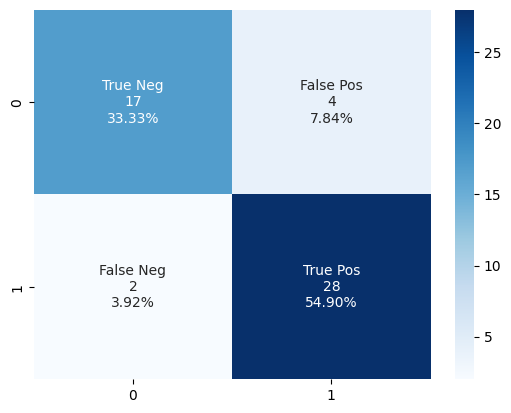

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

cf_matrix = confusion_matrix(
    y_true=all_scores_dict["y_true_"+subscore],
    y_pred=all_scores_dict["y_pred_"+subscore])
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labs = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labs = np.asarray(labs).reshape(2,2)
sns.heatmap(cf_matrix, annot=labs, fmt='', cmap='Blues')

#### Cohen's QWK

In [10]:
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(
    y1=all_scores_dict["y_true_"+subscore],
    y2=all_scores_dict["y_pred_"+subscore],
    weights="quadratic")

0.7536231884057971

### Runoff Direction Reasoning

#### (Macro) F1

In [11]:
from sklearn.metrics import classification_report

# Runoff Direction Reasoning
subscore = IN_COLS[3]

print(classification_report(
    y_true=all_scores_dict["y_true_"+subscore],
    y_pred=all_scores_dict["y_pred_"+subscore])
)

              precision    recall  f1-score   support

           0       1.00      0.89      0.94        46
           1       0.50      1.00      0.67         5

    accuracy                           0.90        51
   macro avg       0.75      0.95      0.80        51
weighted avg       0.95      0.90      0.92        51



Confusion matrix.

<Axes: >

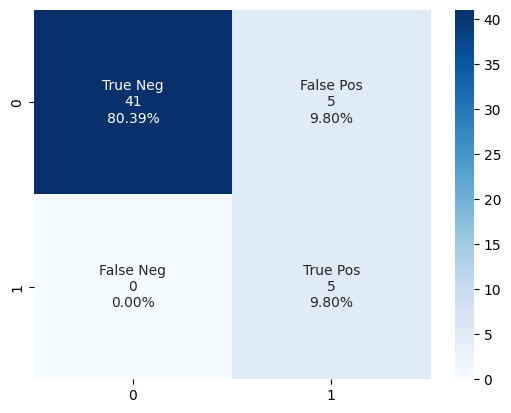

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

cf_matrix = confusion_matrix(
    y_true=all_scores_dict["y_true_"+subscore],
    y_pred=all_scores_dict["y_pred_"+subscore])
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labs = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labs = np.asarray(labs).reshape(2,2)
sns.heatmap(cf_matrix, annot=labs, fmt='', cmap='Blues')

#### Cohen's QWK

In [13]:
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(
    y1=all_scores_dict["y_true_"+subscore],
    y2=all_scores_dict["y_pred_"+subscore],
    weights="quadratic")

0.6165413533834587

### Arrow Size

#### (Macro) F1

In [14]:
from sklearn.metrics import classification_report

# Arrow Size
subscore = IN_COLS[4]

print(classification_report(
    y_true=all_scores_dict["y_true_"+subscore],
    y_pred=all_scores_dict["y_pred_"+subscore])
)

              precision    recall  f1-score   support

           0       0.94      0.91      0.93        35
           1       0.82      0.88      0.85        16

    accuracy                           0.90        51
   macro avg       0.88      0.89      0.89        51
weighted avg       0.90      0.90      0.90        51



Confusion matrix.

<Axes: >

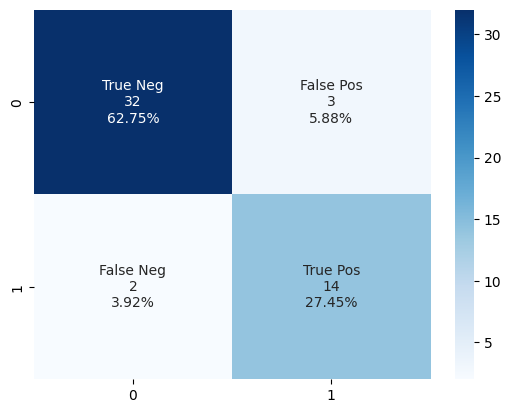

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

cf_matrix = confusion_matrix(
    y_true=all_scores_dict["y_true_"+subscore],
    y_pred=all_scores_dict["y_pred_"+subscore])
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labs = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labs = np.asarray(labs).reshape(2,2)
sns.heatmap(cf_matrix, annot=labs, fmt='', cmap='Blues')

#### Cohen's QWK

In [16]:
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(
    y1=all_scores_dict["y_true_"+subscore],
    y2=all_scores_dict["y_pred_"+subscore],
    weights="quadratic")

0.7761194029850746

### Arrow Size Reasoning

#### (Macro) F1

In [17]:
from sklearn.metrics import classification_report

# Arrow Size Reasoning
subscore = IN_COLS[5]

print(classification_report(
    y_true=all_scores_dict["y_true_"+subscore],
    y_pred=all_scores_dict["y_pred_"+subscore])
)

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        47
           1       0.57      1.00      0.73         4

    accuracy                           0.94        51
   macro avg       0.79      0.97      0.85        51
weighted avg       0.97      0.94      0.95        51



Confusion matrix.

<Axes: >

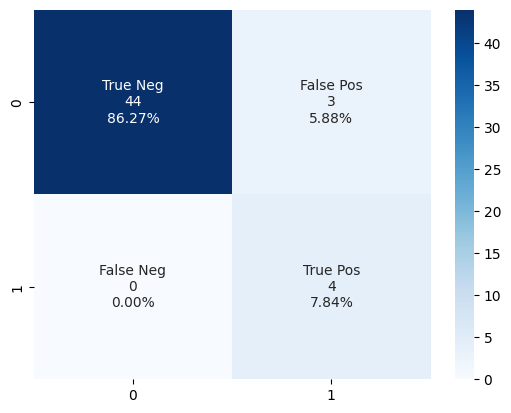

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

cf_matrix = confusion_matrix(
    y_true=all_scores_dict["y_true_"+subscore],
    y_pred=all_scores_dict["y_pred_"+subscore])
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labs = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labs = np.asarray(labs).reshape(2,2)
sns.heatmap(cf_matrix, annot=labs, fmt='', cmap='Blues')

#### Cohen's QWK

In [19]:
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(
    y1=all_scores_dict["y_true_"+subscore],
    y2=all_scores_dict["y_pred_"+subscore],
    weights="quadratic")

0.697029702970297

### Total Score

#### (Macro) F1

In [20]:
# Total Score
print(classification_report(
    y_true=all_scores_dict["y_true_"+IN_COLS[-1]],
    y_pred=all_scores_dict["y_pred_"+IN_COLS[-1]])
)

              precision    recall  f1-score   support

           0       0.82      0.78      0.80        18
           1       0.76      0.68      0.72        19
           2       0.56      0.56      0.56         9
           3       1.00      0.50      0.67         2
           4       0.43      1.00      0.60         3

    accuracy                           0.71        51
   macro avg       0.71      0.70      0.67        51
weighted avg       0.74      0.71      0.71        51



Confusion matrix.

In [21]:
cf_matrix = confusion_matrix(
    y_true=all_scores_dict["y_true_"+IN_COLS[-1]],
    y_pred=all_scores_dict["y_pred_"+IN_COLS[-1]]
)

cf_matrix

array([[14,  3,  1,  0,  0],
       [ 3, 13,  3,  0,  0],
       [ 0,  1,  5,  0,  3],
       [ 0,  0,  0,  1,  1],
       [ 0,  0,  0,  0,  3]])

#### Cohen's QWK

In [22]:
cohen_kappa_score(
    y1=all_scores_dict["y_true_"+IN_COLS[-1]],
    y2=all_scores_dict["y_pred_"+IN_COLS[-1]],
    weights="quadratic"
)

0.823121387283237

For this sample of Q3 formative assessment responses, even though the total scores' Macro F1 appears low, you can see there is still relative alignment between the model and the human.

This is evidenced by the confusion matrix, which shows only 4/51 instances where the model and the human differed by more than 1 point, all of which were due to false positives. This alignment is reflected in the QWK, which indicates "strong" agreement (QWK > 0.80) between the model and the reviewer.

As we saw during our actual analysis, the model is again prone more to false positives (i.e., overscoring) than false negatives (i.e., underscoring) before Active Learning.